# Section 2: CIFAR-10 Image Classification with Transfer Learning

## Loading Model

Transfer learning will be used with Google's vit-base-patch16-224 which can be found here: https://huggingface.co/google/vit-base-patch16-224?library=transformers. The model uses 224x224 images but has its own processor to deal with resizing and other transformations. The result of that processing is a dictionary that includes a 3x224x224 tensor.

In [2]:
from transformers import TFViTModel

# Load model (without output layer)
print('Loading from Hugging Face ...')
base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224')
base_model.save_pretrained('baseline_vit_model')

/apps/tensorflow/2.18/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-16 00:58:23.975804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744779503.999351 2308149 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744779504.006655 2308149 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744779504.025828 2308149 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

Loading from Hugging Face ...


2025-04-16 00:58:31.971284: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task

In [3]:
# Show layers
print('Original Layers')
print('------------------')

for layer in base_model.layers:
    print(layer)

Original Layers
------------------


## Loading Data

The data will be loaded (processing will be done later with training).

In [4]:
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train
X_test = X_test
y_train = y_train
y_test = y_test

## Initial Training

The main layers will be frozen, but the output layer will be replaced to allow for 10 classes. It is very minimalistic so that there can be a baseline.

In [5]:
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Sequential
from transformers import TFViTModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import keras
import time

# Wrapper to convert to Keras layer
class ViTLayer(Layer):
    def __init__(self, vit_model=None, model_name='google/vit-base-patch16-224', **kwargs):
        super(ViTLayer, self).__init__(**kwargs)
        # Load vit_model
        self.vit_model = vit_model if vit_model is not None else TFViTModel.from_pretrained('baseline_vit_model')
        # Store model name for serialization (needed for saving/loading)
        self.model_name = model_name
    
    def call(self, inputs):
        outputs = self.vit_model(inputs)
        return outputs.pooler_output
    
    def get_config(self):
        config = super(ViTLayer, self).get_config()
        config.update({
            'model_name': self.model_name
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        # Get model_name and remove it from config to avoid passing to init
        model_name = config.pop('model_name')
        # Create instance without vit_model (will be loaded in init)
        return cls(model_name=model_name, **config)

# Form new model
model = Sequential([
    Input(shape=(3, 224, 224)),
    ViTLayer(base_model, model_name='google/vit-base-patch16-224'),
    Dense(10, activation='softmax', name='classifier')
])

# Show layers
print(f'Layers: {model.layers}')

# Freeze everything except output layer
model.layers[0].trainable = False

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(model.summary())

Layers: [<ViTLayer name=vi_t_layer, built=True>, <Dense name=classifier, built=True>]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vi_t_layer (ViTLayer)           │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 10)             │         7,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

None


Start training (using K-Fold Cross Validation). Due to time constraints, only half of the training data will be used for fitting but it will be shuffled and randomly chosen to avoid sample bias.

In [6]:
from transformers import AutoImageProcessor

# Tracking metrics
start_time = time.time()
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

# Process in batches and each batch with KFold cross validation
num_batches = 50
num_kfolds = 4
batch_kf = StratifiedKFold(n_splits=num_batches, shuffle=True, random_state=42)
val_kf = StratifiedKFold(n_splits=num_kfolds, shuffle=True, random_state=42)
batch_num = 1

for _, batch_index in batch_kf.split(X_train, y_train):
    
    print('-------------------------------------')
    print(f'Working on Batch {batch_num} ...')
    print('-------------------------------------')
    X_train_batch = X_train[batch_index]
    y_train_batch = y_train[batch_index]
    fold_num = 1
    
    for train_index, val_index in val_kf.split(X_train_batch, y_train_batch):
        
        print(f'Working on Fold {fold_num} ...')
        X_train_split = X_train_batch[train_index]
        y_train_split = y_train_batch[train_index]
        X_val_split = X_train_batch[val_index]
        y_val_split = y_train_batch[val_index]
        
        processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
        X_train_split = processor(images=X_train_split, return_tensors='tf')['pixel_values']
        X_val_split = processor(images=X_val_split, return_tensors='tf')['pixel_values']
        
        history = model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=1)
        train_accuracy += history.history['accuracy']
        val_accuracy += history.history['val_accuracy']
        train_loss += history.history['loss']
        val_loss += history.history['val_loss']
        fold_num += 1
        
    # Train on half of the training set
    if batch_num == int(round(num_batches/2)):
        break
        
    batch_num += 1
    
# Print time it took to train
end_time = time.time()
train_time_secs = end_time - start_time
train_time_mins = train_time_secs / 60
print(f'Training Time: {train_time_mins} mins')

-------------------------------------
Working on Batch 1 ...
-------------------------------------
Working on Fold 1 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.2956 - loss: 2.0610 - val_accuracy: 0.8520 - val_loss: 1.0355
Working on Fold 2 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9112 - loss: 0.8060 - val_accuracy: 0.9280 - val_loss: 0.4957
Working on Fold 3 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9510 - loss: 0.4174 - val_accuracy: 0.9440 - val_loss: 0.3472
Working on Fold 4 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9544 - loss: 0.3138 - val_accuracy: 0.9760 - val_loss: 0.2084
-------------------------------------
Working on Batch 2 ...
-------------------------------------
Working on Fold 1 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9581 - loss: 0.2600 - val_accuracy: 0.9560 - val_loss: 0.2498
Working on Fold 2 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9640 - loss: 0.2217 - val_accuracy: 0.956

In [7]:
from tensorflow.keras.models import load_model

# Save model
model.save('baseline_transfer_model.keras')

Some preliminary metrics will be shown ...

Best Training Accuracy: 0.9866666793823242
Best Validation Accuracy: 1.0
Average Training Accuracy: 0.9634400016069412
Average Validation Accuracy: 0.9707600003480912
Last Training Accuracy: 0.9773333072662354
Last Validation Accuracy: 0.9959999918937683


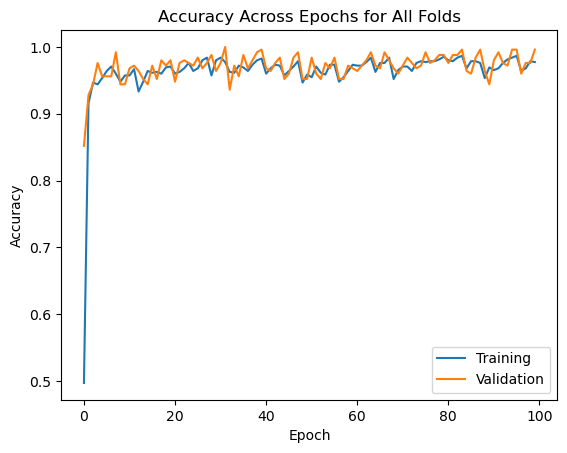

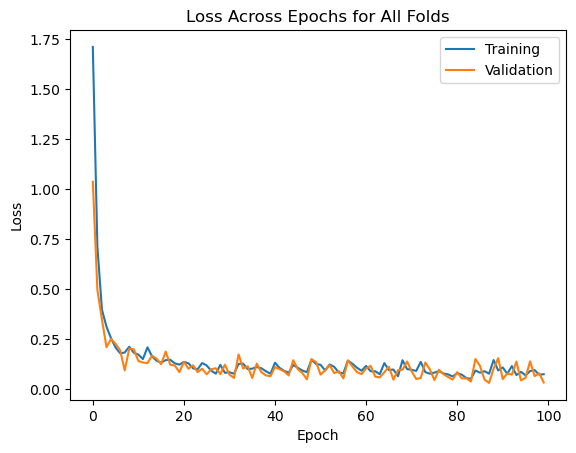

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Print accuracies across all epochs and folds
print(f'Best Training Accuracy: {max(train_accuracy)}')
print(f'Best Validation Accuracy: {max(val_accuracy)}')
print(f'Average Training Accuracy: {np.mean(train_accuracy)}')
print(f'Average Validation Accuracy: {np.mean(val_accuracy)}')
print(f'Last Training Accuracy: {train_accuracy[-1]}')
print(f'Last Validation Accuracy: {val_accuracy[-1]}')

# Plot accuracy
num_total_epochs = len(train_accuracy)
plt.plot(range(num_total_epochs), train_accuracy, label='Training')
plt.plot(range(num_total_epochs), val_accuracy, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Across Epochs for All Folds')
plt.legend()
plt.show()

# Plot loss
num_total_epochs = len(train_loss)
plt.plot(range(num_total_epochs), train_loss, label='Training')
plt.plot(range(num_total_epochs), val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Across Epochs for All Folds')
plt.legend()
plt.show()

Training Performance for Batch 1
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step
Time to Predict: 94.90864443778992 secs

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       100
           1       0.99      1.00      1.00       100
           2       0.99      0.93      0.96       100
           3       0.92      0.93      0.93       100
           4       0.93      1.00      0.97       100
           5       0.97      0.93      0.95       100
           6       0.97      0.98      0.98       100
           7       1.00      1.00      1.00       100
           8       0.95      0.97      0.96       100
           9       0.97      0.97      0.97       100

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000


Confusion Matrix


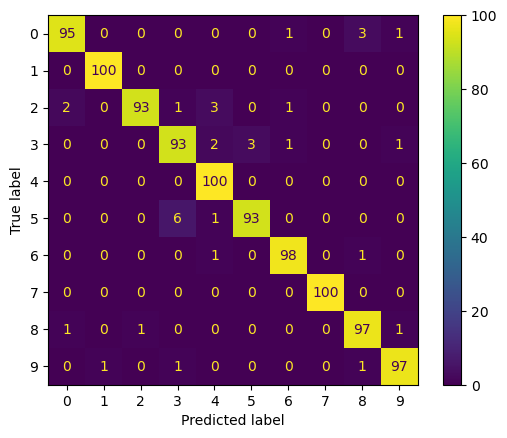


Training Performance for Batch 25
----------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step
Time to Predict: 94.51385283470154 secs

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.99      0.98      0.98       100
           2       0.99      1.00      1.00       100
           3       0.93      0.96      0.95       100
           4       1.00      0.99      0.99       100
           5       0.98      0.94      0.96       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       0.98      0.99      0.99       100
           9       0.99      1.00      1.00       100

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.99      1000
weighted avg       0.99      0.98      0.99      1000


Confusion Matrix


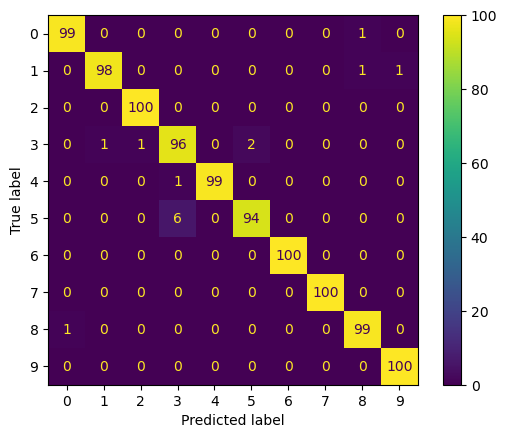

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedKFold, train_test_split

# Function to evaluate performance
def evaluate(model, X_true, y_true):

    """ Evaluate Model Performance """

    # List class names in order
    class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"]

    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_true)
    y_pred = np.argmax(y_pred, axis=-1)
    end_time = time.time()
    pred_time_secs = end_time - start_time
    print(f'Time to Predict: {pred_time_secs} secs')
    print()

    # Precision, Recall, F1-score
    print('Classification Report')
    print(classification_report(y_true, y_pred))
    print()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

# Show performance on first batch and last batch
batch_kf = StratifiedKFold(n_splits=num_batches, shuffle=True, random_state=42)
batch_num = 1

for _, batch_index in batch_kf.split(X_train, y_train):
    
    if batch_num == 1 or batch_num == int(round(num_batches/2)):
        print(f'Training Performance for Batch {batch_num}')
        print('----------------------------------------------')
        X_train_batch = X_train[batch_index]
        y_train_batch = y_train[batch_index]
        processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
        X_train_batch = processor(images=X_train_batch, return_tensors='tf')['pixel_values']
        evaluate(model, X_train_batch, y_train_batch)
        print()
        
    batch_num += 1

In [10]:
"""
------------------------------------------------
Example of Loading Model for Future Reference
------------------------------------------------

# Wrapper to convert to Keras layer
class ViTLayer(Layer):
    def __init__(self, vit_model=None, model_name='google/vit-base-patch16-224', **kwargs):
        super(ViTLayer, self).__init__(**kwargs)
        # Load vit_model
        self.vit_model = vit_model if vit_model is not None else TFViTModel.from_pretrained('baseline_vit_model')
        # Store model name for serialization (needed for saving/loading)
        self.model_name = model_name
    
    def call(self, inputs):
        outputs = self.vit_model(inputs)
        return outputs.pooler_output
    
    def get_config(self):
        config = super(ViTLayer, self).get_config()
        config.update({
            'model_name': self.model_name
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        # Get model_name and remove it from config to avoid passing to init
        model_name = config.pop('model_name')
        # Create instance without vit_model (will be loaded in init)
        return cls(model_name=model_name, **config)

# Load model
loaded_model = load_model('baseline_transfer_model.keras', custom_objects={'ViTLayer': ViTLayer})
    
# Make predictions
y_true = y_train
X_true = X_train
y_pred = loaded_model.predict(X_true)
y_pred = np.argmax(y_pred, axis=-1)
print('Classification Report')
print(classification_report(y_true, y_pred))
"""

"\n------------------------------------------------\nExample of Loading Model for Future Reference\n------------------------------------------------\n\n# Wrapper to convert to Keras layer\nclass ViTLayer(Layer):\n    def __init__(self, vit_model=None, model_name='google/vit-base-patch16-224', **kwargs):\n        super(ViTLayer, self).__init__(**kwargs)\n        # Load vit_model\n        self.vit_model = vit_model if vit_model is not None else TFViTModel.from_pretrained('baseline_vit_model')\n        # Store model name for serialization (needed for saving/loading)\n        self.model_name = model_name\n    \n    def call(self, inputs):\n        outputs = self.vit_model(inputs)\n        return outputs.pooler_output\n    \n    def get_config(self):\n        config = super(ViTLayer, self).get_config()\n        config.update({\n            'model_name': self.model_name\n        })\n        return config\n    \n    @classmethod\n    def from_config(cls, config):\n        # Get model_name and